# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

sns.set_style('dark')


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

from torchvision import transforms

from unet import UNet
from torchinfo import summary

In [2]:
data_path = os.path.join('.', 'data')

train_path = os.path.join(data_path, 'train', 'train')
val_path = os.path.join(data_path, 'validation')
test_path = os.path.join(data_path, 'test', 'test')

# Display some images

In [3]:
def show_images(ct,dose,possible_dose_mask,structure_masks,sample_idx=0,**kwargs):

        structure_masks = structure_masks.squeeze(0)
        fig, ax = plt.subplots(2, 2)
        ax = ax.flatten()
        ax[0].imshow(ct.squeeze(), cmap='gray', vmin=0, vmax=ct.max())
        ax[0].set_title('CT')
        ax[1].imshow(dose.squeeze())
        ax[1].set_title('Dose')
        ax[2].imshow(possible_dose_mask.squeeze())
        ax[2].set_title('Possible dose mask')
        for organ in structure_masks:
            ax[3].imshow(organ)
        ax[3].set_title('Structure masks')

        for axis in ax:
            axis.axis('off')

        plt.tight_layout()
        plt.suptitle('Sample '+str(sample_idx))
        plt.show()

In [4]:
def show_random_images(path,n):
    id_exs = np.random.randint(0, 7799,n)
    for id_ex in id_exs:
        sample_path = os.path.join(path, 'sample_'+str(id_ex))
        ct_path = os.path.join(sample_path, 'ct.npy')
        dose_path = os.path.join(sample_path, 'dose.npy')
        possible_dose_mask_path = os.path.join(sample_path, 'possible_dose_mask.npy')
        structure_masks_path = os.path.join(sample_path, 'structure_masks.npy')

        ct = torch.from_numpy(np.load(ct_path)).unsqueeze(0)
        dose = torch.from_numpy(np.load(dose_path)).unsqueeze(0)
        possible_dose_mask = torch.from_numpy(np.load(possible_dose_mask_path)).unsqueeze(0)
        structure_masks = torch.from_numpy(np.load(structure_masks_path)).unsqueeze(0)
        

        show_images(ct,dose,possible_dose_mask,structure_masks,sample_idx=id_ex)

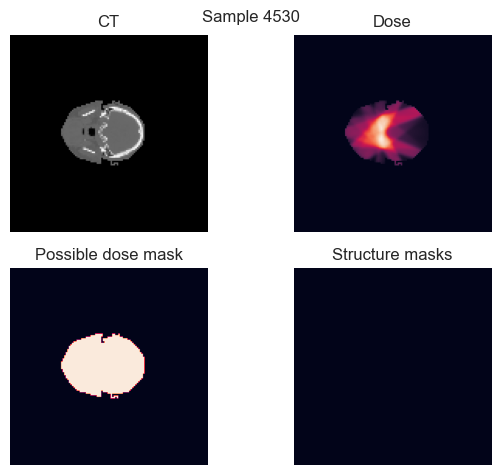

In [5]:
show_random_images(train_path, 1)

In [6]:
#Manual load of a sample
id_ex = 0
sample_path = os.path.join(train_path, 'sample_'+str(id_ex))
ct_path = os.path.join(sample_path, 'ct.npy')
dose_path = os.path.join(sample_path, 'dose.npy')
possible_dose_mask_path = os.path.join(sample_path, 'possible_dose_mask.npy')
structure_masks_path = os.path.join(sample_path, 'structure_masks.npy')

ct = torch.from_numpy(np.load(ct_path)).unsqueeze(0)
dose = torch.from_numpy(np.load(dose_path)).unsqueeze(0)
possible_dose_mask = torch.from_numpy(np.load(possible_dose_mask_path)).unsqueeze(0)
structure_masks = torch.from_numpy(np.load(structure_masks_path))


# Mean and Std of Dataset

In [7]:
from datasetsDLMI import DLMI_Train, DLMI_Test

In [8]:
mean_ct = np.load(os.path.join(data_path, 'mean_ct.npy'))
std_ct = np.load(os.path.join(data_path, 'std_ct.npy'))
mean_dose = np.load(os.path.join(data_path, 'mean_dose.npy'))
std_dose = np.load(os.path.join(data_path, 'std_dose.npy'))

In [9]:
print(
    'mean_ct: ', mean_ct,
    'std_ct: ', std_ct,
    'mean_dose: ', mean_dose,
    'std_dose: ', std_dose
)

mean_ct:  97.59464646559495 std_ct:  298.82489850204036 mean_dose:  2.945620140701685 std_dose:  10.749361438151379


In [10]:
def compute_mean_std(loader):
    mean_ct = 0.
    std_ct = 0.

    mean_dose = 0.
    std_dose = 0.
    nb_samples = 0.

    for (ct, _, _), dose in tqdm(loader):
        batch_samples = ct.size(0)

        ct = ct.view(batch_samples, ct.size(1), -1)
        dose = dose.view(batch_samples, dose.size(1), -1)

        mean_ct += ct.mean((1,2)).sum(0)
        std_ct += ct.std((1,2)).sum(0)

        mean_dose += dose.mean((1,2)).sum(0)
        std_dose += dose.std((1,2)).sum(0)

        nb_samples += batch_samples

    mean_ct /= nb_samples
    std_ct /= nb_samples

    mean_dose /= nb_samples
    std_dose /= nb_samples

    print(f"{mean_ct=}, {std_ct=}, {mean_dose=}, {std_dose=}")
    return mean_ct, std_ct, mean_dose, std_dose

In [11]:
# vanilla_train = DLMI_Train(train_path,ct_transform=None,dose_transform=None)
# vanilla_train_loader = DataLoader(vanilla_train, batch_size=1, shuffle=False, num_workers=0)
# mean_ct, std_ct, mean_dose, std_dose = compute_mean_std(vanilla_train_loader)
# # Save these values
# data_path = os.path.join('.', 'data')
# np.save(os.path.join(data_path, 'mean_ct.npy'), mean_ct)
# np.save(os.path.join(data_path, 'std_ct.npy'), std_ct)
# np.save(os.path.join(data_path, 'mean_dose.npy'), mean_dose)
# np.save(os.path.join(data_path, 'std_dose.npy'), std_dose)

# Definition of the model

In [12]:
num_workers = 0
lr = 1e-3
batch_size = 16
num_epochs = 100
gpu = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
exp_dir = os.path.join('.', 'exp2')
os.makedirs(exp_dir, exist_ok=True)

In [13]:
from augmentations import ct_transform,aug_transform,test_transform

train_dataset = DLMI_Train(train_path, None, None)
val_dataset = DLMI_Train(val_path, ct_transform)
test_dataset = DLMI_Test(test_path, test_transform)

In [14]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 7800
Val dataset size: 1200
Test dataset size: 1200


In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [16]:
print("Number of batches in train loader: ", len(train_loader))
print("Number of batches in val loader: ", len(val_loader))
print("Number of batches in test loader: ", len(test_loader))

Number of batches in train loader:  488
Number of batches in val loader:  75
Number of batches in test loader:  75


In [17]:
model = UNet( n_channels=12, n_classes=1,use_pos_dose_mask=True,channels_list=[16,32,64,128,256])

In [18]:
# col_names = ['input_size', 'output_size', 'num_params']
summary(model, input_size=(1,12, 128, 128), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 128, 128]          --
├─ConvBatchNorm: 1-1                     [1, 16, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 16, 128, 128]         1,744
│    └─BatchNorm2d: 2-2                  [1, 16, 128, 128]         32
│    └─ReLU: 2-3                         [1, 16, 128, 128]         --
├─DownBlock: 1-2                         [1, 32, 64, 64]           --
│    └─MaxPool2d: 2-4                    [1, 16, 64, 64]           --
│    └─Sequential: 2-5                   [1, 32, 64, 64]           --
│    │    └─ConvBatchNorm: 3-1           [1, 32, 64, 64]           4,704
│    │    └─ConvBatchNorm: 3-2           [1, 32, 64, 64]           9,312
├─DownBlock: 1-3                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-6                    [1, 32, 32, 32]           --
│    └─Sequential: 2-7                   [1, 64, 32, 32]           --
│    │

# Load a model to inspect

In [19]:
exp_dir = os.path.join('.', 'exp9')

model = UNet( n_channels=12, n_classes=1,use_pos_dose_mask=True)
optimizer = optim.SGD(model.parameters(), lr=1, momentum=0.9)
gpu =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(gpu)

cuda:0


In [20]:
load_path = os.path.join(exp_dir, 'model.pth')
ckpt = torch.load(load_path, map_location="cpu")
start_epoch = ckpt["epoch"]
model.load_state_dict(ckpt["model"])
model = model.to(gpu)
optimizer.load_state_dict(ckpt["optimizer"])

In [21]:
def predict(model, loader, device,n_preds=None):
    ''' Predicts the output of the model on the given dataset loader
    
    Parameters
    ----------
    model : torch.nn.Module
        The model to predict on
    loader : torch.utils.data.DataLoader
        The dataloader containing the dataset to predict on
    device : torch.device
        The device to run the model on
    n_preds : int
        The number of batches to go through. Default is 1

    Returns
    -------
    input : np.ndarray
        The input to the model. Shape (n_preds*batch_size, 12, 128, 128)
    preds : np.ndarray
        The predictions of the model. Shape (n_preds*batch_size, 1, 128, 128)
    ground_truth : np.ndarray
        The ground truth of the model. Shape (n_preds*batch_size, 1, 128, 128)
    '''
    model.eval()

    if n_preds is None:
        n_preds = len(loader)

    with torch.no_grad():
        seen = 0
        pbar = tqdm(loader, total=n_preds)
        for batch_idx,(x,y,idx) in enumerate(pbar):
            x = x.to(device).float()

            output = model(x)
            output = output.cpu().numpy()

            if batch_idx == 0:
                input = x.cpu().numpy()
                preds = output
                ground_truth = y.numpy()
            else:
                preds = np.concatenate((preds, output), axis=0)
                ground_truth = np.concatenate((ground_truth, y.numpy()), axis=0)
                input = np.concatenate((input, x.cpu().numpy()), axis=0)

            seen += 1

            if seen >= n_preds:
                # Set the pbdar to 100% to make sure it is done
                print("Done")
                break

    return input,preds, ground_truth

In [22]:
input,preds,ground_truth = predict(model, val_loader, gpu, n_preds=None)

 99%|█████████▊| 74/75 [00:37<00:00,  1.96it/s]

Done


## Display the worst results

Mean MAE: 0.3922


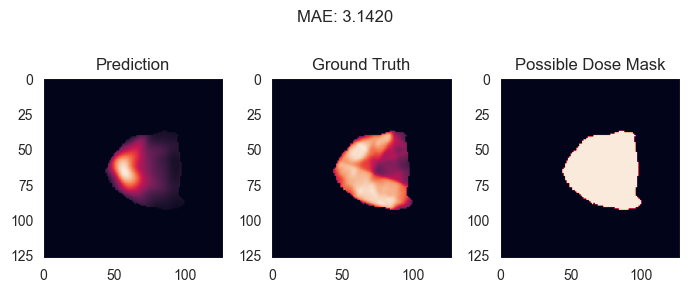

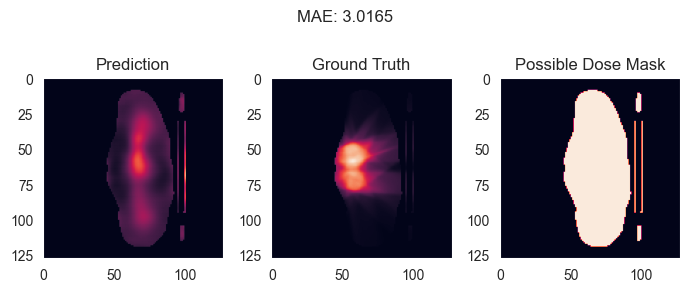

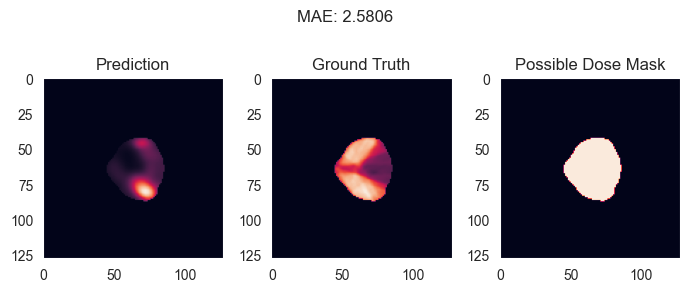

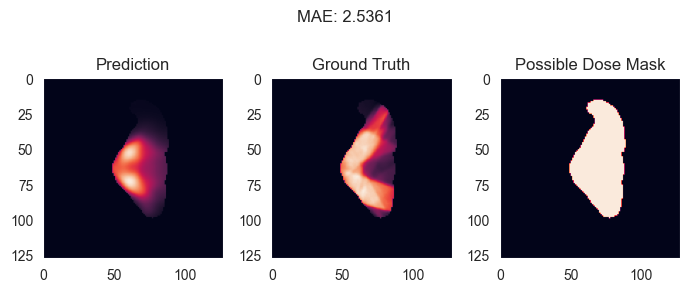

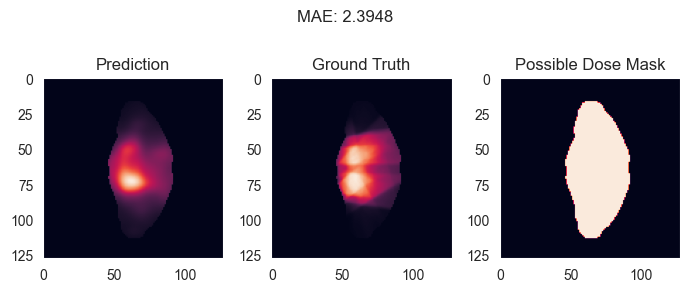

In [23]:
n_val = len(input)
mae = np.zeros(n_val)

# Compute the MAE
for i in range(n_val):
    pred_model = preds[i].squeeze()
    gt = ground_truth[i].squeeze()
    possible_dose_mask = input[i,1].squeeze()

    pred = np.where(possible_dose_mask, pred_model, 0)

    mae[i] = np.mean(np.abs(pred - gt))

print(f"Mean MAE: {np.mean(mae):.4f}")


nb_to_show = 5

worst_idx = np.argsort(-mae)[:nb_to_show]
for idx in worst_idx :
  pred_model = preds[idx].squeeze()
  gt = ground_truth[idx].squeeze()
  possible_dose_mask = input[idx,1].squeeze()

  pred = np.where(possible_dose_mask, pred_model, 0)

  mae_value = mae[idx] 

  fig, ax = plt.subplots(1,3, figsize=(7,3))
  ax[0].imshow(pred)
  ax[0].set_title("Prediction")
  ax[1].imshow(gt)
  ax[1].set_title("Ground Truth")
  ax[2].imshow(possible_dose_mask)
  ax[2].set_title("Possible Dose Mask")
  plt.suptitle(f"MAE: {mae_value:.4f}")
  plt.tight_layout()
  plt.show()

In [24]:
def get_organ_repartition(dataset, mae=None):
    n = len(dataset)
    repartition = np.zeros(10)
    mae_by_organ = np.zeros(10)
    for i in tqdm(range(n)):
        data = dataset[i]
        summed = data[0][2:].sum(axis=(1,2)).numpy()
        repartition += summed>0
        if mae is not None: 
            mae_value = mae[i]
            mae_by_organ += (summed>0) * mae_value

    mae_by_organ /= repartition.copy()
    repartition /= n

    repartition = {k:np.round(repartition[k], 2) for k in range(10)}
    mae_by_organ = {k:np.round(mae_by_organ[k], 2) if mae is not None else None for k in range(10)}

    return repartition, mae_by_organ

In [25]:
train_repart, _ = get_organ_repartition(train_dataset)
val_repart, mae_by_organ = get_organ_repartition(val_dataset, mae)
test_repart, _ = get_organ_repartition(test_dataset)

print(pd.DataFrame([train_repart, val_repart, test_repart], index=['train', 'val', 'test']))

100%|██████████| 1200/1200 [00:59<00:00, 20.00it/s]

          0     1     2     3     4     5     6     7     8     9
train  0.18  0.72  0.33  0.32  0.10  0.09  0.30  0.73  0.31  0.64
val    0.17  0.75  0.33  0.34  0.13  0.11  0.28  0.78  0.25  0.66
test   0.21  0.76  0.32  0.31  0.07  0.10  0.37  0.75  0.35  0.68


In [26]:
pd.DataFrame([mae_by_organ], index=["val"])

,0,1,2,3,4,5,6,7,8,9
val,0.39,0.37,0.36,0.36,0.73,0.35,0.28,0.38,0.34,0.33


# Examine training - Learning curves

In [27]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

exp_dir = os.path.join('.', 'exp9')
stats_path = os.path.join(exp_dir, 'stats.txt')
best_val_path = os.path.join(exp_dir, 'model.pth')
# best_val_path = os.path.join(exp_dir, 'model_val.pth')

In [28]:
ckpt = torch.load(best_val_path, map_location="cpu")
start_epoch = ckpt["epoch"]
best_epoch = ckpt["epoch"]
best_val_loss = ckpt["loss_val"]

In [29]:
import datetime

dict_list = []
tot_time = 0
t0 = 0
with open(stats_path, 'r') as stats_file:
    for line in stats_file:
        # print(line)
        if line[0] == '{':
            curr_dict = eval(line)
            t = curr_dict['time']
            if t>t0:
                tot_time += t-t0
                t0 = t
            else :
                t0 = t
                tot_time += t
            dict_list.append(curr_dict)
print("Total training time: ", datetime.timedelta(seconds=tot_time))

Total training time:  5:44:51.268832


In [30]:
# From dict list to df
df = pd.DataFrame(dict_list)
df.index = df['epoch']
df = df.drop(columns=['epoch'])
print("Best loss on validation set: ", best_val_loss)
df.tail()

Best loss on validation set:  0.39219534675280254


,loss_train,loss_val,lr,time
epoch,,,,
95,0.303904,0.390920,0.000147,5005.026790
96,0.301225,0.391799,0.000094,5216.928015
97,0.299485,0.392135,0.000055,5429.007935
98,0.300194,0.391632,0.000033,5628.924569
99,0.301802,0.392195,0.000025,5826.894153


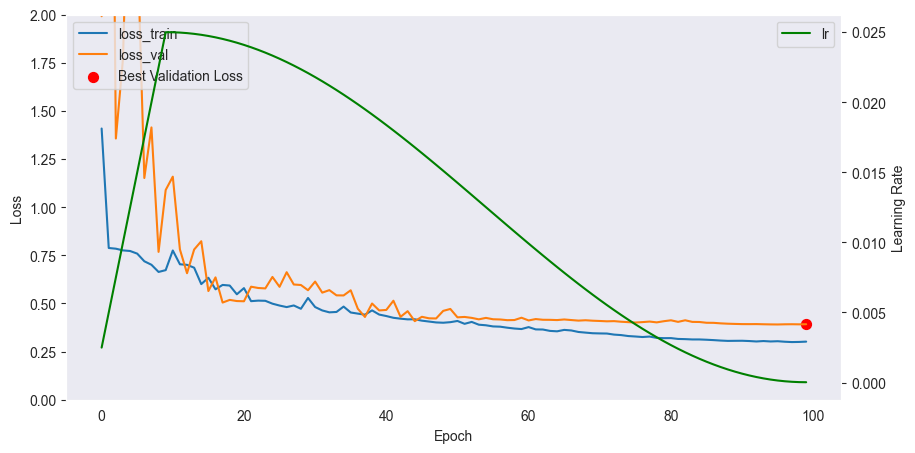

In [31]:
fig, (ax0) = plt.subplots(1,1, figsize=(10,5))
df[["loss_train","loss_val"]].rolling(1).mean().plot(ax=ax0)
ax0.scatter(best_epoch-1, best_val_loss, color='r', marker='.',s=200, label='Best Validation Loss')
ax0.set_ylabel("Loss")
ax0.legend()
plt.ylim(0,2)
ax1 = ax0.twinx()
df.plot(y=['lr'], ax=ax1, color='g')
ax0.legend(loc = 'upper left')
ax1.legend(loc = 'upper right')
ax0.set_xlabel("Epoch")
ax1.set_ylabel("Learning Rate")
plt.show()